In [2]:
# Install prerequisite packages
import sys


In [3]:
from urllib import request, parse
from http.cookiejar import CookieJar
from base64 import b64encode
import getpass
import netrc
import requests
import json
import os
import pprint
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
from rasterio.plot import show
import numpy as np
import time
from netCDF4 import Dataset
from owslib.wms import WebMapService
from owslib.util import Authentication
%matplotlib inline

In [4]:
local_dir = './outputs/'
if not os.path.exists(local_dir):
  os.mkdir(local_dir)

In [5]:
def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    token = None
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        print('Password:')
        password = getpass.getpass()

    # Retrieve existing bearer token or generate a new one if none exists
    basic_auth_string = f'{username}:{password}'
    basic_auth_bytes = basic_auth_string.encode('ascii')
    base64_bytes = b64encode(basic_auth_bytes)
    base64_basic_auth = base64_bytes.decode('ascii')
    try:
        token_response = requests.get(f'https://{endpoint}/api/users/tokens', headers={'Authorization': f'Basic {base64_basic_auth}'})
        token_response_json = token_response.json()
        if token_response_json:
            token = token_response_json[0]['access_token']
        else:
            token_response = requests.post(f'https://{endpoint}/api/users/token', headers={'Authorization': f'Basic {base64_basic_auth}'})
            token_response_json = token_response.json()
            token = token_response_json['access_token']
    except:
        print(f'Error: token response: {token_response_json}')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    return token

class BearerToken(requests.auth.AuthBase):
    def __init__(self, token):
        self.token = token
    def __call__(self, r):
        r.headers['Authorization'] = f'Bearer {self.token}'
        return r

Now call the above function to set up Earthdata Login for subsequent requests

In [6]:
bearer_token = setup_earthdata_login_auth('urs.earthdata.nasa.gov')

def submit_request(url):
    status_req = request.Request(url)
    status_req.add_header('Authorization', f'Bearer {bearer_token}')

    # Open the request and read the response
    with request.urlopen(status_req) as response:
        return response.read()

def get_json_response(url):
    response_data = submit_request(url)
    return json.loads(response_data)

## Identify a data collection of interest

A CMR collection ID is needed to request services through Harmony. The collection ID can be determined using the [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). We will query the corresponding ID of a known collection short name, `harmony_example`, which is a Level 3 test collection with transformation services available through Harmony.

In [7]:
params = {
    'short_name': 'M2T1NXAER',
    'version': '5.12.4'
} # parameter dictionary with known CMR short_name and version

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
query_string = parse.urlencode(params)
url = cmr_collections_url + "?" + query_string
cmr_response = request.urlopen(url)
cmr_results = json.loads(cmr_response.read().decode('utf-8'))

collectionlist = [el['id'] for el in cmr_results['feed']['entry']]
harmony_collection_id = collectionlist[0]
print(harmony_collection_id)

C1276812830-GES_DISC


We can also view the `harmony_example` collection metadata to glean more information about the collection:

In [8]:
pprint.pprint(cmr_results)

{'feed': {'entry': [{'archive_center': 'NASA/GSFC/SED/ESD/TISL/GESDISC',
                     'association_details': {'services': [{'concept_id': 'S2786683405-GES_DISC'},
                                                          {'concept_id': 'S2164732315-XYZ_PROV'},
                                                          {'concept_id': 'S2874702816-XYZ_PROV'}],
                                             'tools': [{'concept_id': 'TL2140660116-GES_DISC'}],
                                             'variables': [{'concept_id': 'V3171509955-GES_DISC'},
                                                           {'concept_id': 'V3171510287-GES_DISC'},
                                                           {'concept_id': 'V3171509615-GES_DISC'},
                                                           {'concept_id': 'V3171509344-GES_DISC'},
                                                           {'concept_id': 'V3171509321-GES_DISC'},
                                        

## Determine service availability

We will determine what services are available for the `harmony_example` collection based on the Harmony capabilities endpoint. 

In [9]:
capabilities_url = f'https://harmony.earthdata.nasa.gov/capabilities?collectionId={harmony_collection_id}'
capabilities = get_json_response(capabilities_url)
capabilities['services']

[{'name': 'giovanni-time-series-adapter',
  'href': 'https://cmr.earthdata.nasa.gov/search/concepts/S2739607260-GES_DISC',
  'capabilities': {'subsetting': {'temporal': True,
    'variable': True,
    'multiple_variable': False},
   'output_formats': ['text/csv']}},
 {'name': 'sds/HOSS-geographic',
  'href': 'https://cmr.earthdata.nasa.gov/search/concepts/S2164732315-XYZ_PROV',
  'capabilities': {'subsetting': {'temporal': True,
    'bbox': True,
    'dimension': True,
    'shape': True,
    'variable': True},
   'output_formats': ['application/netcdf', 'application/x-netcdf4']}}]

According to the services-uat.yml, our `harmony_example` collection is associated with the `harmony/gdal` service with bounding box and variable subsetting, reprojection, and reformatting. We will request these services below. 

## Explore the Harmony Root URL

Harmony conforms to the OGC API - Coverages specification: https://github.com/opengeospatial/ogc_api_coverages.

The basic Harmony URL convention is as follows:

`<harmony_root>/<collection_id>/ogc-api-coverages/1.0.0/`

We will set the Harmony root path with our chosen collection id:

In [10]:
harmony_root = 'https://harmony.earthdata.nasa.gov'
config = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0'
}
coverages_root = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/'.format(**config)
print('Request URL', coverages_root)

Request URL https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/


This root URL of the coverages endpoint provides links to its child resources:

In [11]:
root_json = get_json_response(coverages_root)
pprint.pprint(root_json)

{'links': [{'href': 'https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/',
            'rel': 'self',
            'title': 'this document',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/api',
            'rel': 'service-desc',
            'title': 'the API definition',
            'type': 'text/openapi+yaml;version=3.0'},
           {'href': 'https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/conformance',
            'rel': 'conformance',
            'title': 'OGC conformance classes implemented by this API',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/collections',
            'rel': 'data',
            'title': 'Metadata about the resource collections',
            'type': 'application/json'}]}


The `service_desc` endpoint contains OpenAPI documentation, including information on all supported request parameters: 

In [12]:
service_desc = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/api/'.format(**config)
service_txt = submit_request(service_desc)
print(service_txt)

b'openapi: 3.0.1\ninfo:\n  title: Harmony API conforming to OGC API - Coverages\n  description:\n    "Harmony API for requesting coverages for a range of NASA EOSDIS data\n    using thc OGC API - Coverages"\n  version: 1.0.0\nservers:\n  - url: /{cmrCollectionId}/ogc-api-coverages/1.0.0\n    description: Harmony server\n    variables:\n      cmrCollectionId:\n        default: C1276812830-GES_DISC\n        description: The CMR Collection ID for the dataset whose coverage is being accessed\ntags:\n  - name: Capabilities\n    description: Essential characteristics of this API including information about the data.\n  - name: Coverage\n    description: Access to data (coverage).\npaths:\n  /:\n    get:\n      tags:\n        - Capabilities\n      summary: landing page of this API\n      description:\n        The landing page provides links to the API definition, the Conformance\n        statements and the metadata about the coverage data in this dataset.\n      operationId: getLandingPage\n 

The `conformance` endpoint provides the specifications this API conforms to:

In [13]:
conform_desc = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/conformance/'.format(**config)
conform_json = get_json_response(conform_desc)
print(conform_json)

{'conformsTo': ['http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/collections', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/core']}


The `collections` endpoint provides metadata on the resource collections, which include variable metadata from CMR's [UMM-Var schema](https://git.earthdata.nasa.gov/projects/EMFD/repos/unified-metadata-model/browse/variable) in this example:

In [14]:
collections_desc = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/'.format(**config)
collections_json = get_json_response(collections_desc)
pprint.pprint(collections_json)

{'collections': [{'description': 'Black Carbon Column Mass Density M2T1NXAER '
                                 'v5.12.4 (NASA/GSFC/SED/ESD/TISL/GESDISC)',
                  'extent': {'spatial': {'bbox': [-90, -180, 90, 180],
                                         'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'},
                             'temporal': {'interval': ['1980-01-01T00:00:00.000Z',
                                                       None],
                                          'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}},
                  'id': 'C1276812830-GES_DISC/V3171509330-GES_DISC',
                  'itemType': 'Variable',
                  'links': [{'href': 'https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/collections/BCCMASS/coverage/rangeset',
                             'title': 'Perform rangeset request for BCCMASS'}],
                  'title': 'BCCMASS M2T1NXAER v5.12.4'}],
 'links': [{'href'

In [15]:
def wait_for_job_completion(job_status_url):
    while True:
        try:
            response_json = get_json_response(job_status_url)
            status = response_json.get('status')

            if status != 'previewing' and status != 'running':
                print(f"status: {status}")
                return response_json
            else:
                print("Waiting for 10 seconds before retrying...")
                time.sleep(10)

        except Exception as e:
            print(f"An error occurred: {e}")
            break


In [16]:
from urllib import parse
granule_id = 'G2613562772-GES_DISC'
collection_id = 'C1276812830-GES_DISC'
ogc_api_coverages_version = '1.0.0'

# https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?forceAsync=true&granuleId=G2613562772-GES_DISC&subset=time(%222023-01-01T00%3A00%3A00.000Z%22%3A%222023-01-01T23%3A59%3A59.999Z%22)&format=application%2Fx-netcdf4&variable=TOTEXTTAU&skipPreview=true&label=eed-edsc-prod%2Cedsc-id%3D6103540449
api_path = (
    f"/{collection_id}/ogc-api-coverages/{ogc_api_coverages_version}"
    f"/collections/parameter_vars/coverage/rangeset"
)

bounds = (68.08615233,  6.69169395, 97.47399721, 37.15140621)

west, south, east, north = bounds

# Build query string
query_params = [
    ('granuleid', granule_id),
    ('format', 'application/x-netcdf4'),
    ('variable', 'TOTEXTTAU'),
    ('subset', f'lon({west}:{east})'),
    ('subset', f'lat({south}:{north})'),
]
query_string = parse.urlencode(query_params)
var_url = harmony_root + api_path + '?' + query_string
print('Request URL', var_url)

# Submit the request
var_results = submit_request(var_url)


Request URL https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?granuleid=G2613562772-GES_DISC&format=application%2Fx-netcdf4&variable=TOTEXTTAU&subset=lon%2868.08615233%3A97.47399721%29&subset=lat%286.69169395%3A37.15140621%29


In [17]:
# Turn bytes into a file
with open(local_dir + 'parameter_vars.nc', 'wb') as f:
    f.write(var_results)

# Open the NetCDF file
nc_file = Dataset(local_dir + 'parameter_vars.nc', 'r')


In [18]:
nc_file

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    History: Original file generated: Wed Jan 11 21:46:19 2023 GMT
    Comment: GMAO filename: d5124_m2_jan10.tavg1_2d_aer_Nx.20230101.nc4
    Filename: MERRA2_400.tavg1_2d_aer_Nx.20230101.nc4
    Conventions: CF-1
    Institution: NASA Global Modeling and Assimilation Office
    References: http://gmao.gsfc.nasa.gov
    Format: NetCDF-4/HDF-5
    SpatialCoverage: global
    VersionID: 5.12.4
    TemporalRange: 1980-01-01 -> 2016-12-31
    identifier_product_doi_authority: http://dx.doi.org/
    ShortName: M2T1NXAER
    GranuleID: MERRA2_400.tavg1_2d_aer_Nx.20230101.nc4
    ProductionDateTime: Original file generated: Wed Jan 11 21:46:19 2023 GMT
    LongName: MERRA2 tavg1_2d_aer_Nx: 2d,1-Hourly,Time-averaged,Single-Level,Assimilation,Aerosol Diagnostics
    Title: MERRA2 tavg1_2d_aer_Nx: 2d,1-Hourly,Time-averaged,Single-Level,Assimilation,Aerosol Diagnostics
    SouthernmostLatitude: -90.0
    NorthernmostLat

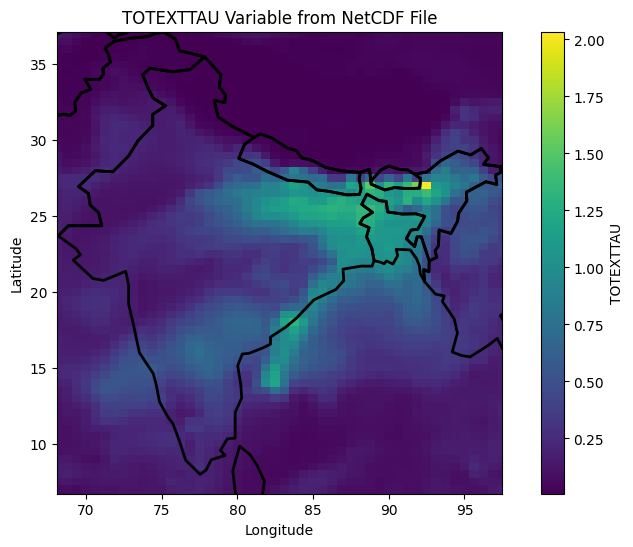

In [20]:
import geopandas as gpd
import zipfile

# Extract data from NetCDF
data = nc_file.variables['TOTEXTTAU'][:]
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]

plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(lon, lat, data[0, :, :], shading='auto')
plt.colorbar(mesh, label='TOTEXTTAU')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('TOTEXTTAU Variable from NetCDF File')

# Set x and y limits on plot
plt.xlim(west, east)
plt.ylim(south, north)

# Ensure shapefile is extracted
shapefile_dir = local_dir + "ne_110m_admin_0_countries/"
india_shapefile = shapefile_dir + "ne_110m_admin_0_countries.shp"
if not os.path.exists(india_shapefile):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(shapefile_dir)

# Read and plot India boundary overlay
india = gpd.read_file(india_shapefile)
india.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=2)

plt.show()


In [34]:
import xarray


xarray.open_dataset(local_dir + 'parameter_vars.nc').attrs.get("RangeBeginningDate")

'2023-01-01'

In [25]:
from urllib import parse
granule_id = 'G2613562772-GES_DISC'
collection_id = 'C1276812830-GES_DISC'
ogc_api_coverages_version = '1.0.0'

# https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?forceAsync=true&granuleId=G2613562772-GES_DISC&subset=time(%222023-01-01T00%3A00%3A00.000Z%22%3A%222023-01-01T23%3A59%3A59.999Z%22)&format=application%2Fx-netcdf4&variable=TOTEXTTAU&skipPreview=true&label=eed-edsc-prod%2Cedsc-id%3D6103540449
api_path = (
    f"/{collection_id}/ogc-api-coverages/{ogc_api_coverages_version}"
    f"/collections/parameter_vars/coverage/rangeset"
)

bounds = (68.08615233,  6.69169395, 97.47399721, 37.15140621)

west, south, east, north = bounds

# Build query string
query_params = [
    ('format', 'application/x-netcdf4'),
    ('variable', 'TOTEXTTAU'),
    ('subset', f'lon({west}:{east})'),
    ('subset', f'lat({south}:{north})'),
    ('subset', 'time("2023-01-01T00:00:00Z":"2023-01-31T23:59:59Z")'),
    ('maxResults', 31),
]
query_string = parse.urlencode(query_params)
var_url = harmony_root + api_path + '?' + query_string
print('Request URL', var_url)

# Submit the request
async_json = get_json_response(var_url)

Request URL https://harmony.earthdata.nasa.gov/C1276812830-GES_DISC/ogc-api-coverages/1.0.0/collections/parameter_vars/coverage/rangeset?format=application%2Fx-netcdf4&variable=TOTEXTTAU&subset=lon%2868.08615233%3A97.47399721%29&subset=lat%286.69169395%3A37.15140621%29&subset=time%28%222023-01-01T00%3A00%3A00Z%22%3A%222023-01-31T23%3A59%3A59Z%22%29&maxResults=31


In [26]:


jobConfig = {
    'jobID': async_json['jobID']
}

job_url = harmony_root+'/jobs/{jobID}'.format(**jobConfig)
print('Job URL', job_url)



Job URL https://harmony.earthdata.nasa.gov/jobs/cebb3ca4-2190-4e3a-b69f-b04318b6c567


In [27]:
job_json = get_json_response(job_url)

print('Job response:')
print()
pprint.pprint(job_json)

Job response:

{'createdAt': '2025-06-13T10:27:50.877Z',
 'dataExpiration': '2025-07-13T10:27:50.877Z',
 'jobID': 'cebb3ca4-2190-4e3a-b69f-b04318b6c567',
 'labels': [],
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/cebb3ca4-2190-4e3a-b69f-b04318b6c567/cancel',
            'rel': 'canceler',
            'title': 'Cancels the job.',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/jobs/cebb3ca4-2190-4e3a-b69f-b04318b6c567/pause',
            'rel': 'pauser',
            'title': 'Pauses the job.',
            'type': 'application/json'},
           {'bbox': [-180, -90, 180, 90],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/cebb3ca4-2190-4e3a-b69f-b04318b6c567/101879546/M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20230101_TOTEXTTAU_subsetted.nc4',
            'rel': 'data',
            'temporal': {'end': '2023-01-01T23:59:59.000Z',
                         'start': '2023-

In [28]:
while job_json['status'] == 'running' and job_json['progress'] < 100:
    print('Job status is running. Progress is ', job_json['progress'], '%. Trying again.')
    time.sleep(10)
    job_json = get_json_response(job_url)
    if job_json['status'] == 'running':
        continue

Job status is running. Progress is  14 %. Trying again.
Job status is running. Progress is  70 %. Trying again.


In [30]:
if job_json['status'] == 'successful' and job_json['progress'] == 100:
    print('Job progress is 100%. Output links printed below:')
    links = [link for link in job_json['links'] if link.get('rel', 'data') == 'data'] #list of data links from response
    for i in range(len(links)):
        link_dict = links[i]
        print(link_dict['href'])
        output_file_name = str(link_dict['title']+'.tif')
        proj_filepath = str(local_dir+output_file_name)
        proj_results = submit_request(link_dict['href'])
        file_ = open(proj_filepath, 'wb')
        file_.write(proj_results)
        file_.close()

Job progress is 100%. Output links printed below:
https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/cebb3ca4-2190-4e3a-b69f-b04318b6c567/101879546/M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20230101_TOTEXTTAU_subsetted.nc4
https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/cebb3ca4-2190-4e3a-b69f-b04318b6c567/101879547/M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20230102_TOTEXTTAU_subsetted.nc4
https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/cebb3ca4-2190-4e3a-b69f-b04318b6c567/101879549/M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20230104_TOTEXTTAU_subsetted.nc4
https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/cebb3ca4-2190-4e3a-b69f-b04318b6c567/101879550/M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20230105_TOTEXTTAU_subsetted.nc4
https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/cebb3ca4-2190-4e3a-b69f-b04318b6c567/101879551/M2T1NXAER.5.

KeyboardInterrupt: 